In [11]:
import os

import numpy as np
import matplotlib.pyplot as plt
from cmocean import cm
from cartopy.crs import LambertAzimuthalEqualArea
from cartopy.feature import LAND
from matplotlib.tri import Triangulation
from scipy.ndimage import gaussian_filter
from scipy.interpolate import RectBivariateSpline
from scipy.spatial import KDTree

import sys
sys.path.insert(0, '../')
from lmsiage.utils import remesh, optimize_mesh, make_polygon_shapely, measure
from lmsiage.remeshing import get_same_elements

%matplotlib inline

In [2]:
ifile = '../mesh_arctic_ease_25km_max7.npz'
srs_dst = LambertAzimuthalEqualArea(central_longitude=0, central_latitude=90)

In [3]:
with np.load(ifile) as ds:
    x0 = ds['x']
    y0 = ds['y']
    t0 = ds['t']
    xc = ds['xc']
    yc = ds['yc']
    mask = ds['mask']

In [4]:
m = gaussian_filter(mask.astype(float), 1, truncate=1)
max_mask_fix_node=0.15
max_mask_zero_speed=0.6
mask = RectBivariateSpline(xc, yc, m[::-1], kx=1, ky=1)(y0, x0, grid=False)
fixed_nodes_idx = np.nonzero(mask < max_mask_fix_node)[0]
zero_speed = np.nonzero(mask < max_mask_zero_speed)[0]

In [5]:
force = False
min_edge_length = 13
max_edge_length = 38
min_edge_angle = 15
min_triangles = 5
search_dist = 50
max_dist0 = 50
min_area = 20
max_mask_fix_node=0.15
max_mask_zero_speed=0.6


u = 11
v = 13
x1 = np.array(x0)
y1 = np.array(y0)
block_mask = (x1 > 0) & (y1 < 0) & (x1 < 200) & (y1 > -200)
x1[block_mask] = x1[block_mask] + u
y1[block_mask] = y1[block_mask] + v

u0 = x1 - x0
v0 = y1 - y0

tri1 = Triangulation(x1, y1, t0)
tri2 = remesh(tri1, fixed_nodes_idx, min_area, min_edge_length, min_edge_angle, max_edge_length, verbose=True)
tri3 = optimize_mesh(tri1, tri2, fixed_nodes_idx)


Removed 0 small elements
Collapsed 6 short edges
Collapsed 1 small angle edges
Removed 24 long edges


In [15]:
area1, edges1, perim1, ap_ratio1= measure(x1, y1, t0)

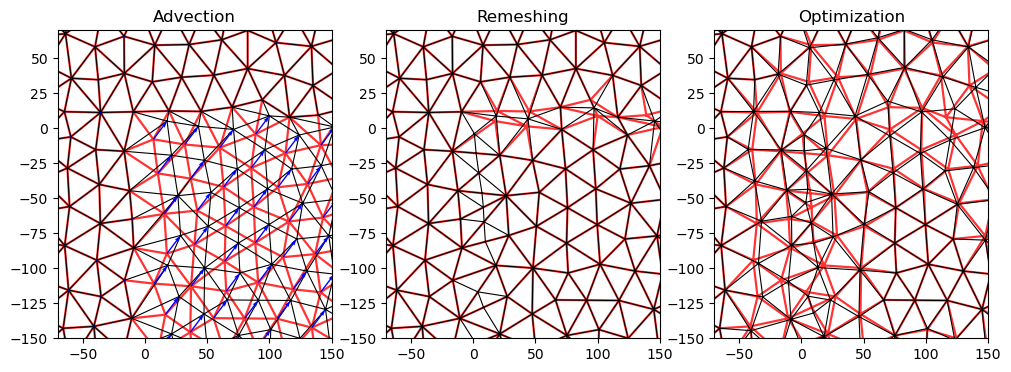

In [6]:
lw_thick = 1.6
lw_thin = 0.8
fig, axs = plt.subplots(1, 3, figsize=(12, 4))
tcf = axs[0].triplot(x0, y0, t0, 'r-', lw=lw_thick, alpha=0.8)
tcf = axs[0].triplot(x1, y1, t0, 'k-', lw=lw_thin)
axs[0].quiver(x0, y0, u0, v0, scale=1, scale_units='xy', angles='xy', color='b', width=0.005)

tcf = axs[1].triplot(x1, y1, t0, 'r-', lw=lw_thick, alpha=0.8)
tcf = axs[1].triplot(tri2, 'k-', lw=lw_thin)

tcf = axs[2].triplot(tri2, 'r-', lw=lw_thick, alpha=0.8)
tcf = axs[2].triplot(tri3, 'k-', lw=lw_thin)

for ax in axs:
    ax.set_xlim([-70, 150])
    ax.set_ylim([-150, 70])

axs[0].set_title('Advection')
axs[1].set_title('Remeshing')
axs[2].set_title('Optimization')
plt.savefig('figure06_optimization.png', dpi=200, bbox_inches='tight', pad_inches=0.1)


In [ ]:
same_elems_in1, same_elems_in2 = get_same_elements(tri1.triangles, tri2.triangles)
mask2 = np.isin(np.arange(len(tri2.triangles)), same_elems_in2)

In [64]:
tri2x = np.floor(tri2.x[tri2.triangles] * 0.5)
tri3x = np.floor(tri3.x[tri3.triangles] * 0.5)
same_elems_in2, same_elems_in3 = get_same_elements(tri2x, tri3x)
mask3 = np.isin(np.arange(len(tri3.triangles)), same_elems_in3)

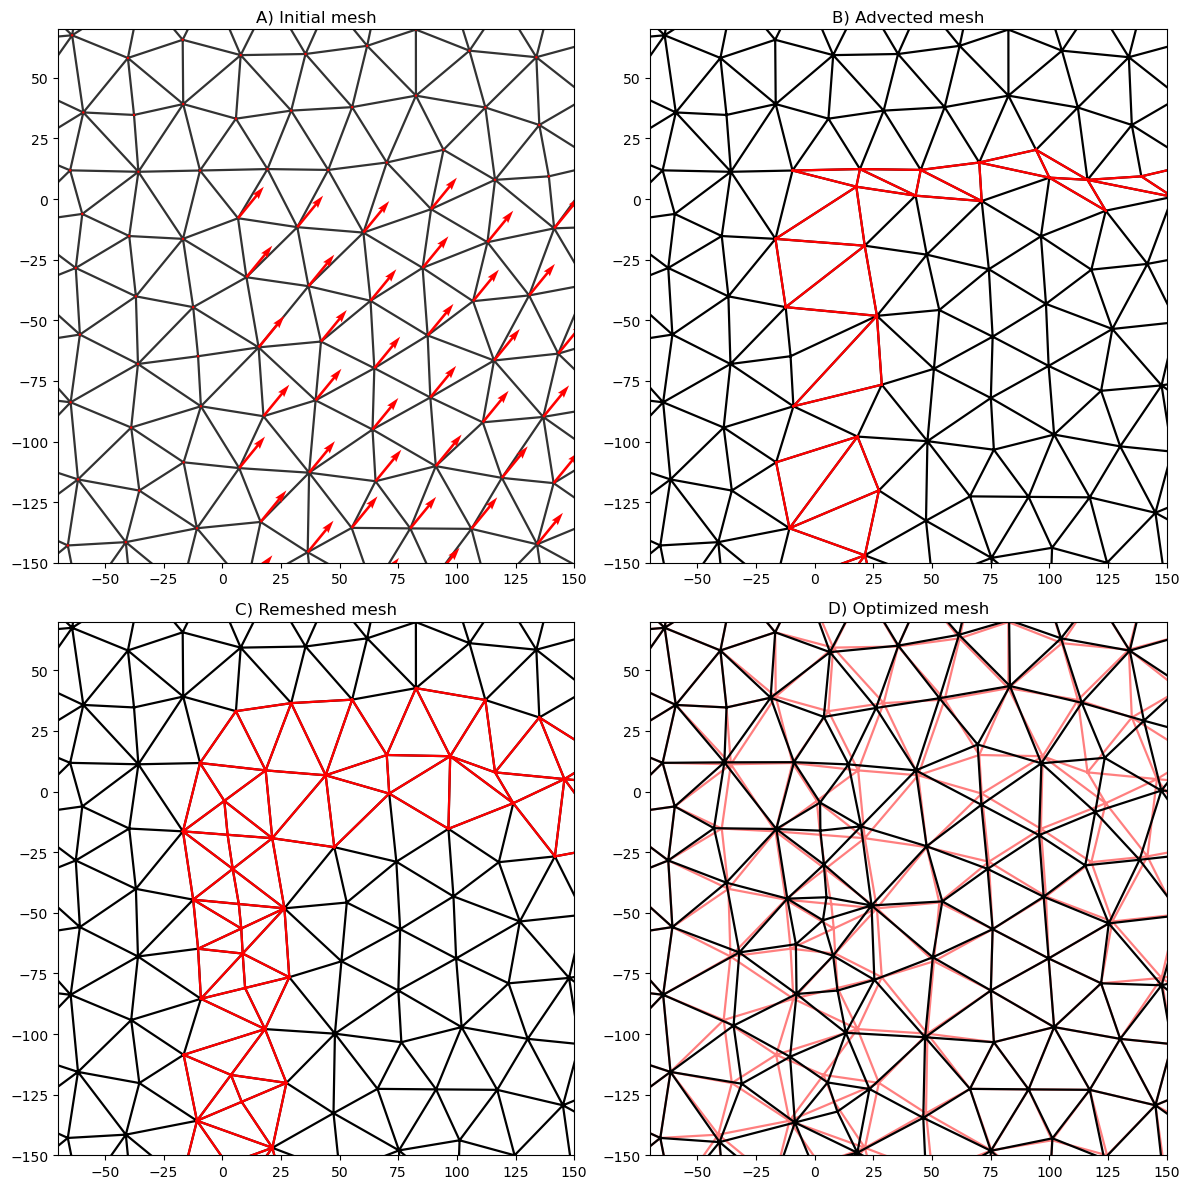

In [73]:
lw_thick = 1.6
lw_thin = 0.8
fig, axs = plt.subplots(2, 2, figsize=(12, 12))
tcf = axs[0, 0].triplot(x0, y0, t0, 'k-', lw=lw_thick, alpha=0.8)
axs[0, 0].quiver(x0, y0, u0, v0, scale=1, scale_units='xy', angles='xy', color='r', width=0.005)

mask1 = (area1 < 200) + (area1 > 450)
tcf = axs[0, 1].triplot(x1, y1, t0, 'k-', lw=lw_thick)
tcf = axs[0, 1].triplot(x1, y1, t0, 'r-', lw=lw_thick, mask=~mask1)

#tcf = axs[1].triplot(x1, y1, t0, 'r-', lw=lw_thick, alpha=0.8)
tcf = axs[1, 0].triplot(tri2, 'k-', lw=lw_thick)
tcf = axs[1, 0].triplot(tri2.x, tri2.y, tri2.triangles,'r-', lw=lw_thick, mask=mask2)

tcf = axs[1, 1].triplot(tri2, 'r-', lw=lw_thick, alpha=0.5)
tcf = axs[1, 1].triplot(tri3, 'k-', lw=lw_thick)
#tcf = axs[1, 1].triplot(tri3.x, tri3.y, tri3.triangles, 'r-', lw=lw_thick, mask=mask3)

for ax in axs.flat:
    ax.set_xlim([-70, 150])
    ax.set_ylim([-150, 70])

axs[0, 0].set_title('A) Initial mesh')
axs[0, 1].set_title('B) Advected mesh')
axs[1, 0].set_title('C) Remeshed mesh')
axs[1, 1].set_title('D) Optimized mesh')
plt.tight_layout()
plt.savefig('figure06_optimization_v2.png', dpi=200, bbox_inches='tight', pad_inches=0.1)


In [ ]:
tri_a, tri_o = tri1, tri3
xa, ya, ta = tri_a.x, tri_a.y, tri_a.triangles
xo, yo, to = tri_o.x, tri_o.y, tri_o.triangles
same_in_a, same_in_o = get_same_elements(xa[ta], xo[to])
new_elems = np.ones(tri_o.triangles.shape[0], dtype=bool)
new_elems[same_in_o] = False
new_elem_idx = np.nonzero(new_elems)[0]

src2dst = np.column_stack([same_in_a, same_in_o]).tolist()
weights = [1] * len(src2dst)
elem_xa = xa[ta].mean(axis=1)
elem_ya = ya[ta].mean(axis=1)
treea = KDTree(np.column_stack([elem_xa, elem_ya]))


In [ ]:
new_elem_idx.size

In [ ]:
good_i = [3560]
for i in good_i:
    polygons = []
    inter_polygons = []
    src2dst = []
    weights = []
    x = xo[to[i]].mean()
    y = yo[to[i]].mean()
    near_elems_1 = treea.query_ball_point([x, y], search_dist)
    po = make_polygon_shapely(xo[to[i]], yo[to[i]])
    for j in near_elems_1:
        pa = make_polygon_shapely(xa[ta[j]], ya[ta[j]])
        p_int = po.intersection(pa)
        if p_int.area > 0:
            src2dst.append((j, i))
            weights.append(p_int.area / po.area)
            polygons.append(pa)
            inter_polygons.append(p_int)
    plot_margin = 30
    xlim = [x - plot_margin, x + plot_margin]
    ylim = [y - plot_margin, y + plot_margin]
    print(i)
    plt.figure(figsize=(5, 5))
    plt.triplot(xa, ya, ta, 'r-', lw=0.4, alpha=0.8)
    plt.triplot(xo, yo, to, 'k-', lw=1)
    for inter_polygon in inter_polygons:
        #plt.plot(*inter_polygon.exterior.xy, lw=1)
        l = plt.plot(*inter_polygon.exterior.xy, lw=0)
        plt.fill(*inter_polygon.exterior.xy, alpha=0.3, color=l[0].get_color(), label='Highlighted region')

    plt.axis('equal')
    plt.xlim(xlim)
    plt.ylim(ylim)
    plt.savefig(f'figure07_intersection_{i}.png', dpi=200, bbox_inches='tight', pad_inches=0.1)
    plt.show()
